In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets.cifar import CIFAR10
from torch.optim import Adam
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
from torchvision.transforms import ToPILImage

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 512
data_dir = r'./cifar10/'
train_dataset = CIFAR10(data_dir,  download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,
                                  pin_memory=torch.cuda.is_available())

print("训练样本个数：",len(train_dataset))

cuda


100%|██████████| 170498071/170498071 [00:59<00:00, 2886349.30it/s] 


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
训练样本个数： 50000


样本形状： torch.Size([512, 3, 32, 32])
样本标签：  0:airplane, 4:deer , 5:dog  , 4:deer , 6:frog , 3:cat  , 2:bird , 3:cat  , 5:dog  , 9:truck


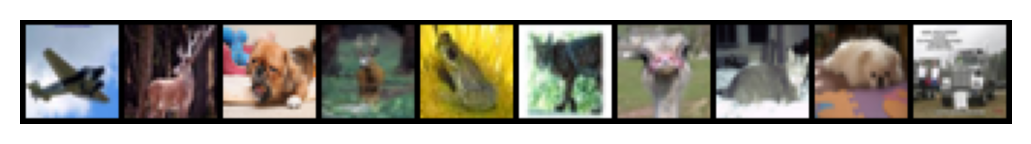

In [3]:
def imshowrow(imgs,nrow):
    plt.figure(dpi=200)#figsize=(9, 4),
    _img=ToPILImage()(torchvision.utils.make_grid(imgs,nrow=nrow ))
    plt.axis('off')
    plt.imshow(_img)
    plt.savefig(r'./imgss.png') #保存图片
    plt.show()
    
classes = ('airplane', 'automobile', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

sample = iter(train_loader)
images, labels = next(sample)
print('样本形状：',np.shape(images))
print('样本标签：',','.join('%2d:%-5s' % (labels[j],
                classes[labels[j]]) for j in range(len(images[:10]))))
imshowrow(images[:10],nrow=10)

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = nn.Conv2d(3, 64, kernel_size=4, stride=1) #29
        self.c1 = nn.Conv2d(64, 128, kernel_size=4, stride=1)#26
        self.c2 = nn.Conv2d(128, 256, kernel_size=4, stride=1)#23
        self.c3 = nn.Conv2d(256, 512, kernel_size=4, stride=1)#20
        self.l1 = nn.Linear(512*20*20, 64)

        self.b1 = nn.BatchNorm2d(128)
        self.b2 = nn.BatchNorm2d(256)
        self.b3 = nn.BatchNorm2d(512)

    def forward(self, x):
        h = F.relu(self.c0(x))
        features = F.relu(self.b1(self.c1(h)))#b 128 26 26
        h = F.relu(self.b2(self.c2(features)))
        h = F.relu(self.b3(self.c3(h)))
        encoded = self.l1(h.view(x.shape[0], -1))#b 64
        return encoded, features

In [5]:
class DeepInfoMaxLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=1.0, gamma=0.1):
        super().__init__()

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        self.local_d = nn.Sequential(
            nn.Conv2d(192, 512, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(True),
            nn.Conv2d(512, 1, kernel_size=1))

        self.prior_d = nn.Sequential(
            nn.Linear(64, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 200),
            nn.ReLU(True),
            nn.Linear(200, 1),
            nn.Sigmoid() )
        
        self.global_d_M = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),#b 64 24 24
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3),#b 32 22 22
            nn.Flatten(),)
        self.global_d_fc = nn.Sequential(
            nn.Linear(32 * 22 * 22 + 64, 512),
            nn.ReLU(True),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 1) )

    def GlobalD(self, y, M):
        h = self.global_d_M(M)
        h = torch.cat((y, h), dim=1)
        return self.global_d_fc(h)
        
    def forward(self, y, M, M_prime):
        # see appendix 1A of https://arxiv.org/pdf/1808.06670.pdf
        y_exp = y.unsqueeze(-1).unsqueeze(-1)
        y_exp = y_exp.expand(-1, -1, 26, 26)#b 64 26 26

        y_M = torch.cat((M, y_exp), dim=1)#b 192 26 26
        y_M_prime = torch.cat((M_prime, y_exp), dim=1)#b 192 26 26

        Ej = -F.softplus(-self.local_d(y_M)).mean()
        Em = F.softplus(self.local_d(y_M_prime)).mean()
        LOCAL = (Em - Ej) * self.beta

        Ej = -F.softplus(-self.GlobalD(y, M)).mean()
        Em = F.softplus(self.GlobalD(y, M_prime)).mean()
        GLOBAL = (Em - Ej) * self.alpha

        prior = torch.rand_like(y)
        term_a = torch.log(self.prior_d(prior)).mean()
        term_b = torch.log(1.0 - self.prior_d(y)).mean()
        PRIOR = - (term_a + term_b) * self.gamma

        return LOCAL + GLOBAL + PRIOR

In [6]:
totalepoch = 100
if __name__ == '__main__':
    encoder = Encoder().to(device)
    loss_fn = DeepInfoMaxLoss().to(device)
    optim = Adam(encoder.parameters(), lr=1e-4)
    loss_optim = Adam(loss_fn.parameters(), lr=1e-4)
    
    epoch_loss = []
    for epoch in range(totalepoch+1):
        batch = tqdm(train_loader, total=len(train_dataset) // batch_size)
        train_loss = []
        for x, target in batch:
            x = x.to(device)
    
            optim.zero_grad()
            loss_optim.zero_grad()
            y, M = encoder(x)
            M_prime = torch.cat((M[1:], M[0].unsqueeze(0)), dim=0)
            
            loss = loss_fn(y, M, M_prime)
            train_loss.append(loss.item())
            
            batch.set_description(str(epoch) + ' Loss:%.4f'% np.mean(train_loss[-20:]))
            loss.backward()
            optim.step()
            loss_optim.step()
    
        if epoch % 10 == 0:
            root = Path(r'./DIMmodel/')
            enc_file = root / Path('encoder' + str(epoch) + '.pth')
            loss_file = root / Path('loss' + str(epoch) + '.pth')
            enc_file.parent.mkdir(parents=True, exist_ok=True)
            torch.save(encoder.state_dict(), str(enc_file))
            torch.save(loss_fn.state_dict(), str(loss_file))
    
        epoch_loss.append( np.mean(train_loss[-20:]) )
    
    plt.plot(np.arange(len(epoch_loss)), epoch_loss, 'r') 
    plt.show()


4 Loss:1.0499:  15%|█▌        | 15/97 [02:36<14:18, 10.46s/it]


KeyboardInterrupt: 